# Spatial mapping of cell types across the mouse brain (extra) - illustration video

This notebook demonstrates how to use the **cell2location** model for mapping a single cell transcriptomic reference onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain (Kleshchevnikov et al., in preparation). 

cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and multi-cell spatial transcriptomics to map cell types at scale (Fig below). cell2location leverages reference signatures that are estimated from scRNA-seq profiles, for example using conventional clustering followed by estimation of average gene expression profiles. Based on these reference signatures, mRNA contributions from each of the defined cell types are estimated at each location in the spatial data, which gives rise to both cell type proportions as well as absolute densities of cell types in a spatially resolved manner. In this notebook, we examine and use estimated cell densities of cell types to perform downstream analysis. 

## Loading packages

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd

sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
cell2location

<module 'cell2location' from '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/cell2location/__init__.py'>

## 1. Loading cell2location results <a name="loading"></a>

First, let's load the cell2location results. In the export step of the cell2location pipeline, cell locations are added to `sp_data` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are saved to the results directory. 

We load the results of the model saved into the `adata_vis` Anndata object with spatial data :

In [3]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/'
results_folder2 = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_visium_snrna/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder2}regression_model/'

run_name = 'LocationModelLinearDependentW_59clusters_53208locations_9069genes_default'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp.h5ad'
adata_vis = anndata.read(sp_data_file)

In [4]:
adata_vis.uns['spatial'] = {k: None for k in adata_vis.obs['filename'].unique()}

In [5]:
## snRNAseq reference (raw counts)
reg_mod_name = 'RegressionNBV2Torch_65covariates_40532cells_12819genes'
reg_path = f'{sc_results_folder}{reg_mod_name}/'
adata_snrna_raw = sc.read_h5ad(f'{reg_path}sc_with_UMAP.h5ad')

Alternatively, we can load our model after training. When `'save_model': True`, the trained model `r['mod']` is saved as a pickle file. You can load the model later and continue training. Ff the training was done on a GPU, the model needs to be loaded on a GPU.

```python
pickle_model = results_folder + 'std_model/'+r['run_name']+'/model_.p'
r = pickle.load(open(pickle_model, "rb"))

# model
mod = r['mod']

# anndata object with input data and results
adata_vis = r['sp_data']
```

## 2. Visualisation of cell locations <a name="visualisation"></a>

First, we learn how to visualise cell type locations using the standard scanpy pipeline and our custom script that maps several cell types at once.

Our model outputs the absolute density of cells across locations in two different ways:    
1. Using location weights representing absolute density of cells. This estimation relies on the priors on the number of cells, number of cell types and the average change in sensitivity between technologies.    
2. Using estimated absolute mRNA counts from each cell type. These estimates do not rely on the priors to get the scale right so the values are very robust. Absolute mRNA count = UMI (Unique Molecular Identifier) count.   

For both of these measures, the posterior mean and 5% quantile are used to visualise the results. Posterior mean shows the most likely value while 5% quantile show the density of cells and the mRNA count confidently assigned to each cell type.

For each visium section, 4 panels showing the locations of regulatory programmes of all cell types are plotted and saved to `run name /plots/spatial/`.

Here, we visualise locations of multiple cell types at once using absolute cell density (5% quantile). Six neuronal and glial cell types mapping to different regions of the mouse brain are shown.

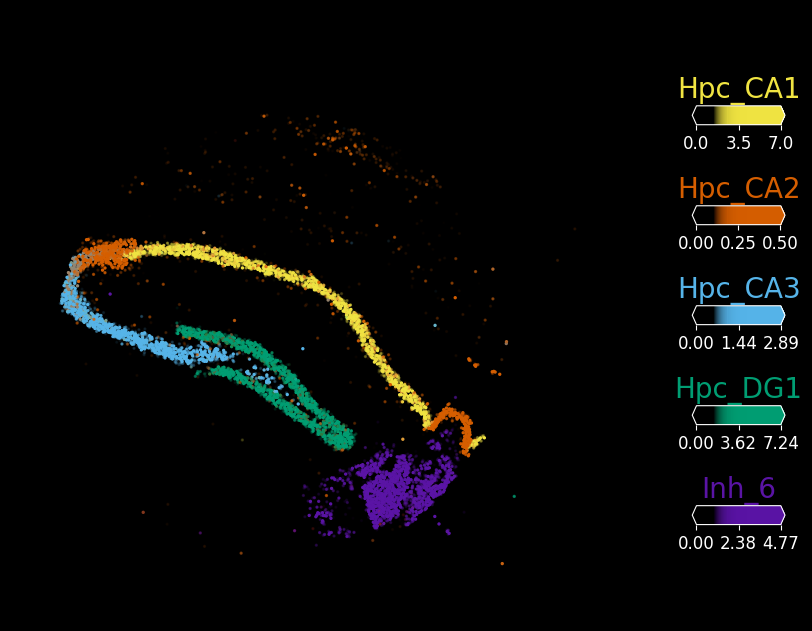

In [6]:
from cell2location.plt.mapping_video import plot_spatial
save_path = f'{results_folder}{run_name}/plots/figures/'

slide = adata_vis

slide.obsm['spatial'] = slide.obsm['spatial'] - slide.obsm['spatial'].min(0) + 500
slide.obsm['spatial'] = slide.obsm['spatial'].astype(int)
images = np.zeros((slide.obsm['spatial'].max(0)[0] + 500, 
                   slide.obsm['spatial'].max(0)[1] + 500, 3))

# select up to 6 clusters 
sel_clust = ['Ext_Hpc_CA1', 'Ext_Hpc_CA2', 'Ext_Hpc_CA3', 'Ext_Hpc_DG1', 'Inh_6']
sel_clust_lab = ['Hpc_CA1', 'Hpc_CA2', 'Hpc_CA3', 'Hpc_DG1', 'Inh_6']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

mpl.rc_file_defaults()
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({"figure.figsize": (10,10)}):

    fig = plot_spatial(slide.obs[sel_clust_col], 
                  coords=slide.obsm['spatial'], 
                  show_img=True, img_alpha=1, img=images,
                  max_color_quantile=0.99, 
                  circle_diameter=1.4, alpha_scaling=1, labels=sel_clust_lab, 
                 style='dark_background', 
                       colorbar_position='right',
                     colorbar_shape={'vertical_gaps': 2, 'horizontal_gaps': 0.18},
                )
    #fig.savefig(f'{save_path}Fig2H_HPC_multicell_maps.pdf',
    #            bbox_inches='tight', facecolor='black')

In [7]:
from cell2location.plt.mapping_video import plot_video_mapping

In [8]:
slide.obs

,filename,xcoord,ycoord,batch,tissue,mean_spot_factorsAstro_AMY,mean_spot_factorsAstro_AMY_CTX,mean_spot_factorsAstro_CTX,mean_spot_factorsAstro_HPC,mean_spot_factorsAstro_HYPO,...,q95_nUMI_factorsLowQ_2,q95_nUMI_factorsMicro,q95_nUMI_factorsNb_1,q95_nUMI_factorsNb_2,q95_nUMI_factorsOPC_1,q95_nUMI_factorsOPC_2,q95_nUMI_factorsOligo_1,q95_nUMI_factorsOligo_2,q95_nUMI_factorsUnk_1,q95_nUMI_factorsUnk_2
AACGTCATAATCGT-2,../Puck_200115_08.digital_expression.txt.gz,888.95,3219.5,2,nan,5.939392,6.332818,5.619437,6.115116,5.859708,...,598.667987,233.898692,243.904359,277.083704,251.206876,304.498120,468.926418,252.529577,171.734666,256.250208
TACTTTAGCGCAGT-2,../Puck_200115_08.digital_expression.txt.gz,4762.20,5020.4,2,nan,7.108025,7.084384,6.272951,7.515004,7.137188,...,343.694411,179.011787,234.643163,259.788853,276.785861,376.629892,715.107404,307.532509,133.611850,237.052621
CATGCCTGGGTTCG-2,../Puck_200115_08.digital_expression.txt.gz,886.50,3199.6,2,nan,3.924167,3.945573,3.581804,4.229127,3.557652,...,426.527611,158.740951,178.578109,189.923080,168.458981,212.098470,295.971321,169.946037,120.592926,171.019600
TCGATATGGCACAA-2,../Puck_200115_08.digital_expression.txt.gz,2237.10,5144.6,2,nan,4.093051,4.145278,3.504191,4.253253,4.198023,...,296.497852,139.186990,175.341042,216.388248,215.015812,298.909010,356.426366,192.968972,107.160955,171.858157
TTATCTGACGAAGC-2,../Puck_200115_08.digital_expression.txt.gz,1031.80,2425.2,2,nan,4.044142,3.970440,3.764144,4.360118,3.740382,...,318.615294,139.611007,157.297436,177.531701,174.455829,228.701366,425.476508,212.502843,110.898141,170.564032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACAATACAGATACT-2,../Puck_200115_08.digital_expression.txt.gz,3025.50,5516.0,2,nan,0.011366,0.005737,0.004204,0.004143,0.010416,...,0.588852,1.165573,0.947032,1.034986,0.588437,0.635138,0.955321,0.718768,1.095026,1.132581
GGTCAGGTTAACGT-2,../Puck_200115_08.digital_expression.txt.gz,3069.70,3211.9,2,nan,0.003503,0.005196,0.002908,0.009107,0.008890,...,0.398394,0.509579,0.353580,0.483797,0.755393,0.259736,0.957955,0.520151,1.002647,0.302914
CATTATGGAATTCT-2,../Puck_200115_08.digital_expression.txt.gz,3507.10,2811.0,2,nan,0.009365,0.006027,0.004099,0.006490,0.005462,...,0.601827,0.712667,0.379097,1.026645,0.463186,0.215698,0.925097,0.549691,0.777396,0.517311
GACTTTTCTTAAAG-2,../Puck_200115_08.digital_expression.txt.gz,2155.00,1264.3,2,nan,0.009092,0.005788,0.004859,0.003904,0.004079,...,0.483352,1.429336,0.736193,0.780615,0.866348,1.738105,2.192244,0.823490,0.994243,0.620166


In [9]:
sel_spot_fact = slide.obs[sel_clust_col]
sel_spot_fact.columns = sel_clust
s = slide.obs['batch'][0]
model_folder = f'{sp_results_folder}{run_name}'

with mpl.rc_context({'figure.figsize': (10, 10),
                    'savefig.facecolor': 'black'}):
    plot_video_mapping(slide, 
                 adata_snrna_raw,
                 slide.obs['batch'], sel_spot_fact,
                 sel_clust, sel_clust,
                 sample_id=s, adata_cluster_col='annotation_1', cell_fact_df=None,
                 step_n=list((np.array([30, 80, 15, 45, 80, 30]) * 0.4).astype(int)),  
                 step_quantile=[1, 1, 1, 1, 0.99, 0.99],
                
                 sc_point_size=3, aver_point_size=20, sp_point_size=1.4,
                 sc_alpha=0.6, sp_alpha=1, sc_power=20, sp_power=20, 
                 sc_accel_power=3, sp_accel_power=3, sc_accel_decel=True, sp_accel_decel=False,
                       
                 sc_jitter=None, sp_jitter=None, adjust_text=False,
                       
                 sp_img=images, sc_img=images, sp_img_scaling_fac=1,
                       
                 save_path=model_folder+'/mapping_video/',
                 style='dark_background', 
                 colorbar_shape={'vertical_gaps': 2, 'horizontal_gaps': 0.18}
                      )
    
model_folder+'/mapping_video/'

(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)
(7718, 2)
(3015, 2)
(3407, 2)
(12243, 2)
(26825, 2)



'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/LocationModelLinearDependentW_59clusters_53208locations_9069genes_default/mapping_video/'

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [10]:
# install ffmpeg and zlib: conda activate cellpymcr3 && conda install -c conda-forge ffmpeg zlib
# use -r (rate) to adjust frames per second 
!cd /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/LocationModelLinearDependentW_59clusters_53208locations_9069genes_default/mapping_video/ && cat `ls | sort -V` | ffmpeg -f image2pipe -r 24 -c:v png -i - -vf scale=1080:-2 -pix_fmt yuv420p ../mapping_video_distinct.mp4
!cd /nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/stickels_et_al_2020_slide_seqV2/LocationModelLinearDependentW_59clusters_53208locations_9069genes_default/mapping_video/ && cat `ls | sort -V` | ffmpeg -f image2pipe -r 24 -c:v png -i - -vf scale=1080:-2 -pix_fmt yuv420p ../mapping_video_distinct.gif

ffmpeg version 4.3.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.5.0 (crosstool-NG 1.24.0.131_87df0e6_dirty)
  configuration: --prefix=/nfs/team283/vk7/software/miniconda3farm5/envs/cellpymcr3 --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1596712246804/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
Input #0, image2pipe, from

Modules and their versions used for this analysis

In [11]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass


sys 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 5.8.0
IPython.core.release 5.8.0
logging 0.5.1.2
zlib 1.0
traitlets 5.0.5
traitlets._version 5.0.5
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 1.0.15
six 1.15.0
wcwidth 0.2.5
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
ctypes 1.1.0
_ctypes 1.1.0
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
tornado 6.0.4
colorama 0.4.4
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
decimal 1.70
_decimal 1.70
scanpy 1.6.0
numpy 1.19.2
numpy.version 1.19.2
numpy.core 1.19.2
numpy.core._multiarray_umath 3.1
n